100%|██████████| 249456/249456 [00:49<00:00, 5063.69it/s]


Fragment vocabulary size: 53


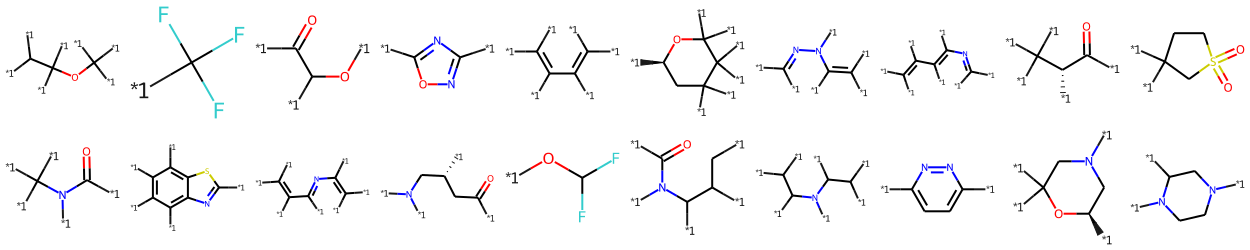

In [1]:
import selfies as sf
from group_selfies.group_mol_graph import Group
from group_selfies.group_grammar import GroupGrammar
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.drawMolsSameScale = False # DrawMolsZoomed
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
# RDLogger.EnableLog('rdApp.*')
import matplotlib.pyplot as plt
import numpy as np
from group_selfies.utils.fragment_utils import fragment_mols
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import re
import random
m = Chem.MolFromSmiles
def grid(mols, molsPerRow=10):
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, maxMols=1000, subImgSize=(125, 125), useSVG=True)

def split_selfies(selfies: str):

    left_idx = selfies.find("[")

    while 0 <= left_idx < len(selfies):
        right_idx = selfies.find("]", left_idx + 1)
        if right_idx == -1:
            raise ValueError("malformed SELFIES string, hanging '[' bracket")

        next_symbol = selfies[left_idx: right_idx + 1]
        yield next_symbol

        left_idx = right_idx + 1
        if selfies[left_idx: left_idx + 1] == ".":
            yield "."
            left_idx += 1

def shuffle(selfies):
    """
    Shuffle a SELFIES string.
    """
    return "".join(sorted(split_selfies(selfies), key=lambda x: random.random()))


# get some molecules from the ZINC dataset
zinc = [x.strip() for x in open('../tests/test_sets/zinc.csv')][1:]

smis = zinc
selfis = [sf.encoder(smi) for smi in tqdm(smis)]

empty_grammar = GroupGrammar()

load_from_disk = True

if load_from_disk:
    grammar = GroupGrammar.from_file('useful30.txt') | GroupGrammar.essential_set() #load
else:
    # extracting a set of reasonable groups using fragmentation
    fragments = fragment_mols(smis, convert=True, method='default', target=500) # use custom fragmentation technique
    vocab_fragment = dict([(f'frag{idx}', Group(f'frag{idx}', frag)) for idx, frag in enumerate(fragments)])
    grammar = GroupGrammar(vocab_fragment)
    grammar.to_file('zinc_test_grammar.txt')

print('Fragment vocabulary size:', len(grammar.vocab))
display(grid([g.mol for g in grammar.vocab.values()][:20]))

In [2]:
def g_encoder(smi):
    # grammar = GroupGrammar.from_file('zinc_test_grammar.txt')
    encoded = grammar.full_encoder(m(smi))
    decoded = Chem.MolToSmiles(grammar.decoder(encoded))
    assert Chem.CanonSmiles(smi) == decoded, (smi, decoded, len(grammar.vocab))
    return encoded

print('Encoding... ', end='')
with Pool() as p:
    gselfis = p.map(g_encoder, smis)
print('Done encoding')

Encoding... Done encoding


In [3]:
smi_lens = [len(smi) for smi in smis]
selfi_lens = [len(list(split_selfies(selfi))) for selfi in selfis]
gselfi_lens = [len(list(split_selfies(gselfi))) for gselfi in gselfis]

In [4]:
import pandas as pd

values = "SMILES|Group SELFIES|SELFIES".split('|')
cat_order = "SMILES|Group SELFIES|SELFIES".split('|')
df = pd.DataFrame({"SMILES": smi_lens, "SELFIES": selfi_lens, "Group SELFIES": gselfi_lens})
df = df.melt(value_vars=values, var_name="Type", value_name="Length of encoding (# of tokens)")

df

,Type,Length of encoding (# of tokens)
0,SMILES,39
1,SMILES,44
2,SMILES,53
3,SMILES,56
4,SMILES,57
...,...,...
748363,SELFIES,44
748364,SELFIES,51
748365,SELFIES,38
748366,SELFIES,42


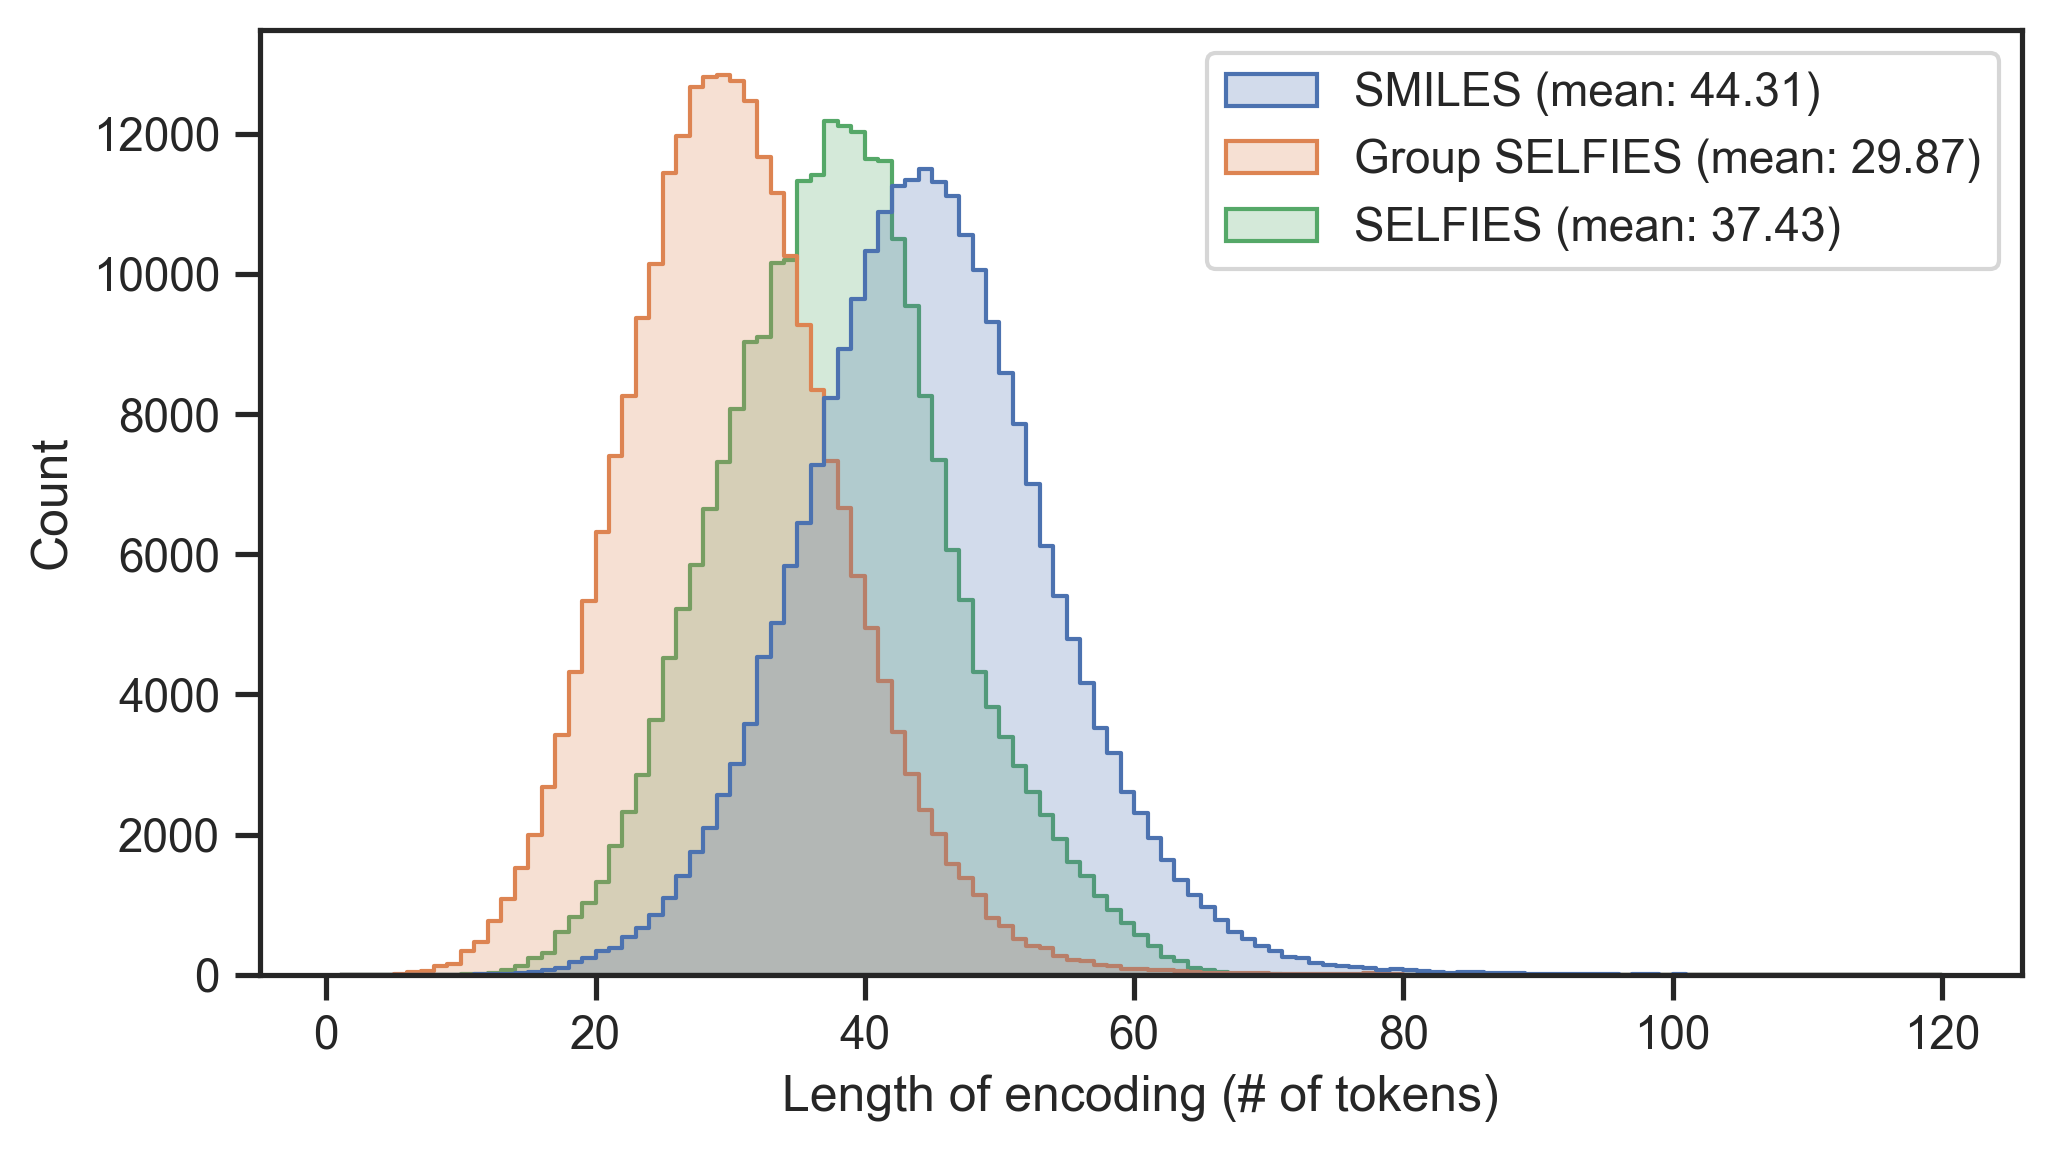

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 1, 2]

# my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]

sns.set(style="ticks")

bins = np.array(range(1, 121))
fig, ax = plt.subplots(figsize=(7, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="Length of encoding (# of tokens)", hue="Type", ax=ax, hue_order=my_cat_order, element='step', bins=bins)
leg = ax.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' (mean: {round(df[df.Type == my_cat_order[i]]["Length of encoding (# of tokens)"].mean(), 2)})')

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('figures/length_hist.png')